In [3]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
from io import StringIO

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [5]:
def get_team_codes():
    """Returns a list of all current NBA team codes"""
    return [
        'ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
        'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
        'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
    ]

In [6]:
def get_number_stats_categories():
    '''Retunrs a list of all the statistics in the advanced game log on
    Basketball Reference that are numberic (eg PtsFwd as opposed to Opponent)'''
    return [
        'PtsFwd', 'PtsAgt', 'ORtg','DRtg', 'Pace', 'FTr', '3PAr',
        'TS%','TRB%', 'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%',
        'ORB%', 'FT/FGA', 'OppeFG%', 'OppTOV%', 'DRB%', 'OppFT/FGA'
       ]

In [7]:
def scrape_team_advanced_gamelog(team_code, year):
    """
    Scrapes advanced game log for a specific team and year.
    
    Args:
        team_code (str): Team code (e.g., 'CHO' for Charlotte).
        year (int): Season year (e.g., 2024 for the 2023-24 season).
    
    Returns:
        pandas.DataFrame: Cleaned advanced game log data, or None if scraping fails.
    """
    url = f"https://www.basketball-reference.com/teams/{team_code}/{year}/gamelog-advanced/"
    
    # Add a polite delay to avoid overloading the server
    time.sleep(5)
    
    try:
        # Fetch the page
        response = requests.get(url)
        response.raise_for_status()
        
        # Check if the page contains valid data
        if "Page Not Found" in response.text:
            print(f"Warning: No data found for {team_code} {year}")
            return None
        
        # Parse the HTML and extract the advanced game log table
        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table', id='tgl_advanced')
        
        if table is None:
            print(f"Warning: No table found for {team_code} {year}")
            return None
        
        # Convert the HTML table to a DataFrame
        df = pd.read_html(StringIO(str(table)))[0]
        
        return df
    
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred for {team_code}: {http_err}")
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred for {team_code}: {conn_err}")
    except Exception as err:
        print(f"An error occurred for {team_code}: {err}")
    
        return None


In [8]:
def get_raw_df(team_code:str, year=2025):
    # Scrape regular season stats
    df = scrape_team_advanced_gamelog(team_code, year)

    # Set column names to the stats they represent
    df.columns = df.columns.get_level_values(1)

    # Make Game Number (G) the index
    df.set_index('G', inplace=True)

    # Drop unneccessary columns
    df.drop(columns=['Rk'], inplace=True)
    df.drop(columns=['Unnamed: 18_level_1'], inplace=True)
    df.drop(columns=['Unnamed: 23_level_1'], inplace=True)


    # Rename columns
    df.rename(columns={'Unnamed: 3_level_1': 'Home/Away'}, inplace=True)
    df.rename(columns={'Tm': 'PtsFwd'}, inplace=True)
    df.rename(columns={'Opp': 'PtsAgt'}, inplace=True)
    df.columns.values[2] = 'Opponent'        # Column indexed at 2 and 5 both titled 'Opp' originally
    df.columns.values[20] = 'OppeFG%'
    df.columns.values[21] = 'OppTOV%'
    df.columns.values[23] = 'OppFT/FGA'

    # Need to drop Opponent here because renaming it above, also Date because of how I set things up
    df.drop(columns=['Date', 'Opponent'], inplace=True)

    # Drop extraneous rows that do not house game info
    df = df[df.index.notnull()]  # Keep only non-NaN indices (ie rows without the 3 collective headers)
    df = df[df.index != "G"]     # Keep only rows wiht games (ie rows without individual stat headers)

    # Edit values in Home/Away column to be 1 and 0
    df['Home/Away'] = df['Home/Away'].fillna('1')
    df['Home/Away'] = df['Home/Away'].replace('@', '0')

    # Edit values in W/L to be 1/0
    df['W/L'] = df['W/L'].replace('W', '1')
    df['W/L'] = df['W/L'].replace('L', '0')

    return df

In [9]:
def get_rolling_avgs(raw_data_df):
    # Take the stats and make them rolling averages (currently past 5 games but may be interesting to optimize)
    number_stats = get_number_stats_categories()
    rolling_avgs = raw_data_df.copy()

    # For every stat that is a number, get the rolling average and drop the non-rolling avg column of that same stat
    for stat in number_stats:
        rolling_avgs[f'Avg_{stat}'] = rolling_avgs[stat].shift().rolling(5).mean()
        rolling_avgs = rolling_avgs.drop(columns=stat)

    # Drop the first five rows becasue they are all NaN
    rolling_avgs = rolling_avgs.drop(index=rolling_avgs.index[:5])

    return rolling_avgs

def get_next_row(raw_data_df, home_away):
    number_stats = get_number_stats_categories()
    
    # Get last 5 games and make an explicit copy
    last_5_games = raw_data_df.tail(5).copy()
    
    # Convert to numeric
    for stat in number_stats:
        last_5_games[stat] = pd.to_numeric(last_5_games[stat], errors='coerce')
    
    # Calculate averages for next game
    next_game_features = {}
    for stat in number_stats:
        next_game_features[f'Avg_{stat}'] = last_5_games[stat].mean()
    
    # Create single row DataFrame with home/away
    next_game_row = pd.DataFrame([next_game_features])
    next_game_row.insert(0, 'Home/Away', home_away)
    
    return next_game_row

In [10]:
def get_standrdized_stats(rolling_avgs_df):
    numeric_features = rolling_avgs_df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    rolling_avgs_df[numeric_features] = scaler.fit_transform(rolling_avgs_df[numeric_features])
    

In [11]:
def logistic_regression(rolling_avgs, next_game_row):

    X = rolling_avgs.drop(columns=['W/L'])
    y = rolling_avgs['W/L']

    # Use 20% of the data for testing, 80% for training
    test_size = int(X.shape[0] * 0.2)

    # Split data into train and test
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    # Train the logistic regression model
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()

    # Predict the next game
    predicted_outcome = model.predict(next_game_row)
    predicted_probability = model.predict_proba(next_game_row)
    print("Predicted Outcome (1=Win, 0=Loss):", predicted_outcome[0])
    print("Win Probability:", predicted_probability[0][1])  # Probability for label 1
    print("Loss Probability:", predicted_probability[0][0])  # Probability for label 0
    print()
    print('y_test', y_test)
    print('y_pred', y_pred)

# 🚨🏀 ***Predicting the Future of NBA Games!*** 🏀🚨

Prepare to witness **data-driven dominance** as we bring cutting-edge machine learning to the court! My technical prowess makes even the most decorated champions pale in comparison to this analytics masterpiece. 🧠📈

With rolling averages, advanced metrics, and a model trained to perfection, we're not just predicting games—we're redefining the game. 🚀✨

This isn’t guesswork. This is **next-level basketball analytics** that leaves luck on the bench.

Ready to see what the future holds? Let’s get that **W**! 🏆🔥

In [ ]:
#bulls = get_raw_df('CHI')
#bulls.tail(5)

,Home/Away,W/L,PtsFwd,PtsAgt,ORtg,DRtg,Pace,FTr,3PAr,TS%,...,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA,OppeFG%,OppTOV%,DRB%,OppFT/FGA
G,,,,,,,,,,,,,,,,,,,,,
78,0,0,98,113,102.7,118.4,95.4,.293,.267,.579,...,7.3,8.9,.547,19.9,21.1,.213,.528,9.2,74.4,.200
79,1,0,117,128,126.4,138.2,92.6,.216,.318,.607,...,4.3,10.6,.591,8.5,32.4,.148,.657,10.7,81.8,.229
80,0,1,127,105,129.0,106.7,98.5,.156,.375,.619,...,14.2,11.9,.604,8.1,26.2,.115,.584,18.7,81.6,.195
81,0,1,129,127,122.7,120.8,105.1,.286,.357,.585,...,8.6,14.0,.561,10.5,32.7,.194,.628,10.8,90.7,.221
82,0,0,119,120,115.2,116.1,93.6,.158,.307,.551,...,14.5,5.1,.525,10.0,28.8,.129,.571,17.3,64.4,.176


In [ ]:
#bulls_next_game = get_next_row(bulls, 1)
#bulls_next_game

,Home/Away,Avg_PtsFwd,Avg_PtsAgt,Avg_ORtg,Avg_DRtg,Avg_Pace,Avg_FTr,Avg_3PAr,Avg_TS%,Avg_TRB%,...,Avg_STL%,Avg_BLK%,Avg_eFG%,Avg_TOV%,Avg_ORB%,Avg_FT/FGA,Avg_OppeFG%,Avg_OppTOV%,Avg_DRB%,Avg_OppFT/FGA
0,1,118.0,118.6,119.2,120.04,97.04,0.2218,0.3248,0.5882,52.12,...,9.78,10.1,0.5656,11.4,28.24,0.1598,0.5936,13.34,78.58,0.2042


In [159]:
#
# Scrape the advanced stats for two NBA teams that are going to play each other next (eg. CHI and BOS)
bulls = get_raw_df('CHI')
celtics = get_raw_df('BOS')

# Get the rolling averages and next game stats for each team and 1 if they're home, 0 if away
bulls_rolling_avg = get_rolling_avgs(bulls)
bulls_next_game = get_next_row(bulls, 1)

celtics_rolling_avg = get_rolling_avgs(celtics)
celtics_next_game = get_next_row(celtics, 0)

# Standardize the features
get_standrdized_stats(bulls_rolling_avg)
get_standrdized_stats(celtics_rolling_avg)

# Run the logistic regression
logistic_regression(bulls_rolling_avg, bulls_next_game)
print()
logistic_regression(celtics_rolling_avg, celtics_next_game)




Accuracy: 0.4666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.46      0.86      0.60         7

    accuracy                           0.47        15
   macro avg       0.48      0.49      0.40        15
weighted avg       0.48      0.47      0.39        15


Predicted Outcome (1=Win, 0=Loss): 0
Win Probability: 3.6730064034155123e-09
Loss Probability: 0.9999999963269935

y_test G
68    1
69    1
70    0
71    0
72    0
73    1
74    0
75    1
76    0
77    1
78    0
79    0
80    1
81    1
82    0
Name: W/L, dtype: object
y_pred ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '0' '0']

Accuracy: 0.7333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.77      0.91      0.83        11

    accuracy                           0.73        15
   macro 

**Separate the stuff I've done with the stuff CHAT's done/I haven't explored**

**Make the separation more apparent**

In [ ]:
# Train a Random Forest model
model = RandomForestClassifier()
#model.fit(X_train, y_train)

# Extract feature importances
importances = model.feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

          Feature  Importance
5        Avg_Pace    0.106608
17    Avg_OppeFG%    0.074525
7        Avg_3PAr    0.062124
1      Avg_PtsFwd    0.058438
6         Avg_FTr    0.055248
11       Avg_STL%    0.050158
18    Avg_OppTOV%    0.049624
4        Avg_DRtg    0.048481
10       Avg_AST%    0.047798
19       Avg_DRB%    0.047280
20  Avg_OppFT/FGA    0.045512
3        Avg_ORtg    0.044889
15       Avg_ORB%    0.043915
13       Avg_eFG%    0.042914
14       Avg_TOV%    0.041690
8         Avg_TS%    0.039007
2      Avg_PtsAgt    0.038027
16     Avg_FT/FGA    0.037943
9        Avg_TRB%    0.031675
12       Avg_BLK%    0.028537
0       Home/Away    0.005608


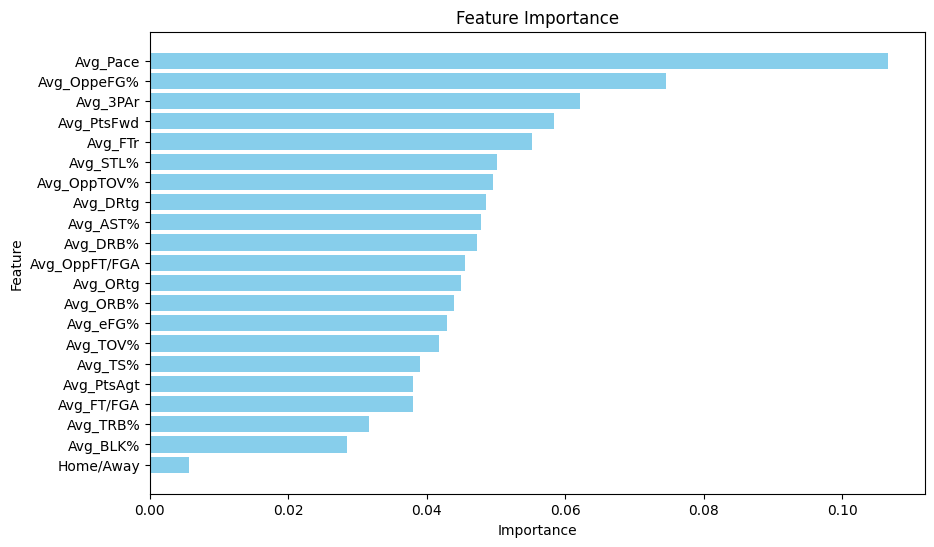

In [29]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Initialize the model
model = LogisticRegression(max_iter=1000)

# Perform RFE
rfe = RFE(model, n_features_to_select=10)  # Adjust the number of features to keep
#rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Avg_PtsFwd', 'Avg_DRtg', 'Avg_3PAr', 'Avg_AST%', 'Avg_STL%',
       'Avg_BLK%', 'Avg_FT/FGA', 'Avg_OppeFG%', 'Avg_OppTOV%',
       'Avg_OppFT/FGA'],
      dtype='object')


In [ ]:
from sklearn.impute import SimpleImputer

def calibrated_logistic_regression(rolling_avgs, next_game_row):
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.pipeline import Pipeline
    
    # Prepare data
    X = rolling_avgs.drop(columns=['W/L'])
    y = rolling_avgs['W/L']
    
    # Get feature columns to ensure consistency
    feature_columns = X.columns
    next_game_row = next_game_row[feature_columns]  # Ensure same columns as training data
    
    # Split data 
    test_size = int(X.shape[0] * 0.2)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]
    
    # Create pipeline with imputer
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', LogisticRegression(class_weight='balanced', C=1.0, random_state=42))
    ])
    
    # Calibrated model
    calibrated_model = CalibratedClassifierCV(
        pipeline, 
        cv=2,
        method='sigmoid'
    )
    
    # Train model
    calibrated_model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = calibrated_model.predict(X_test)
    y_pred_proba = calibrated_model.predict_proba(X_test)
    
    # Evaluate
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()
    
    # Predict next game
    predicted_outcome = calibrated_model.predict(next_game_row)
    predicted_proba = calibrated_model.predict_proba(next_game_row)
    
    print("Predicted Outcome (1=Win, 0=Loss):", predicted_outcome[0])
    print("Win Probability: {:.2%}".format(predicted_proba[0][1]))
    print("Loss Probability: {:.2%}".format(predicted_proba[0][0]))
    
    return calibrated_model, y_test, y_pred

def get_next_row(raw_data_df, home_away):
    # Get and validate stats
    number_stats = get_number_stats_categories()
    number_stats = [stat for stat in number_stats if stat in raw_data_df.columns]
    
    # Get last 5 games and ensure numeric
    last_5_games = raw_data_df.tail(5).copy()
    for stat in number_stats:
        last_5_games[stat] = pd.to_numeric(last_5_games[stat], errors='coerce')
    
    # Calculate averages for next game
    next_game_features = {}
    for stat in number_stats:
        next_game_features[f'Avg_{stat}'] = last_5_games[stat].mean()
    
    # Add derived features
    next_game_features['Off_Eff'] = next_game_features['Avg_ORtg'] * next_game_features['Avg_eFG%']
    next_game_features['Def_Eff'] = next_game_features['Avg_DRtg'] * next_game_features['Avg_OppeFG%']
    next_game_features['Off_Def_Ratio'] = next_game_features['Avg_ORtg'] / next_game_features['Avg_DRtg']
    
    # Calculate Win_Streak from last 5 games
    next_game_features['Win_Streak'] = (last_5_games['W/L'] == '1').sum()
    
    # Create single row DataFrame with home/away
    next_game_row = pd.DataFrame([next_game_features])
    next_game_row.insert(0, 'Home/Away', home_away)
    
    # Standardize features to match training data
    scaler = StandardScaler()
    numeric_features = next_game_row.select_dtypes(include=['float64']).columns
    next_game_row[numeric_features] = scaler.fit_transform(next_game_row[numeric_features])
    
    return next_game_row

def cross_validate_model(X, y, n_splits=2):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from sklearn.pipeline import Pipeline
    
    # Create pipeline with imputer
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
    ])
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_val)
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
        
        acc = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)
        
        accuracies.append(acc)
        aucs.append(auc)
        
        print(f"Fold {fold} - Accuracy: {acc:.3f}, AUC: {auc:.3f}")
    
    print(f"\nAverage Accuracy: {np.mean(accuracies):.3f} (+/- {np.std(accuracies):.3f})")
    print(f"Average AUC: {np.mean(aucs):.3f} (+/- {np.std(aucs):.3f})")


def enhance_features(rolling_avgs_df):
    # Create interaction features
    rolling_avgs_df['Off_Eff'] = rolling_avgs_df['Avg_ORtg'] * rolling_avgs_df['Avg_eFG%']
    rolling_avgs_df['Def_Eff'] = rolling_avgs_df['Avg_DRtg'] * rolling_avgs_df['Avg_OppeFG%']
    
    # Create momentum features (if you have date information)
    rolling_avgs_df['Win_Streak'] = (rolling_avgs_df['W/L'] == '1').rolling(5).sum()
    
    # Create relative metrics
    rolling_avgs_df['Off_Def_Ratio'] = rolling_avgs_df['Avg_ORtg'] / rolling_avgs_df['Avg_DRtg']
    
    # Standardize all numeric features
    scaler = StandardScaler()
    numeric_features = rolling_avgs_df.select_dtypes(include=['float64']).columns
    rolling_avgs_df[numeric_features] = scaler.fit_transform(rolling_avgs_df[numeric_features])
    
    return rolling_avgs_df




Fold 1 - Accuracy: 0.500, AUC: 0.667
Fold 2 - Accuracy: 0.571, AUC: 0.600

Average Accuracy: 0.536 (+/- 0.036)
Average AUC: 0.633 (+/- 0.033)
Accuracy: 0.3333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3


Predicted Outcome (1=Win, 0=Loss): 0
Win Probability: 32.60%
Loss Probability: 67.40%
Fold 1 - Accuracy: 0.571, AUC: 0.667
Fold 2 - Accuracy: 0.833, AUC: 1.000

Average Accuracy: 0.702 (+/- 0.131)
Average AUC: 0.833 (+/- 0.167)
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00    

In [18]:
bulls = get_raw_df('CHI')
bulls_rolling_avg = get_rolling_avgs(bulls)
enhanced_bulls = enhance_features(bulls_rolling_avg)
bulls_next_game = get_next_row(bulls, 1)

# Cross validate
X = enhanced_bulls.drop(columns=['W/L'])
y = enhanced_bulls['W/L']
cross_validate_model(X, y)

# Get prediction
model, y_test, y_pred = calibrated_logistic_regression(enhanced_bulls, bulls_next_game)


celts = get_raw_df('BOS')
celts_rolling_avg = get_rolling_avgs(celts)
enhanced_celts = enhance_features(celts_rolling_avg)
celts_next_game = get_next_row(celts, 1)

# Cross validate
X = enhanced_celts.drop(columns=['W/L'])
y = enhanced_celts['W/L']
cross_validate_model(X, y)

# Get prediction
model, y_test, y_pred = calibrated_logistic_regression(enhanced_celts, celts_next_game)


Fold 1 - Accuracy: 0.500, AUC: 0.667
Fold 2 - Accuracy: 0.571, AUC: 0.600

Average Accuracy: 0.536 (+/- 0.036)
Average AUC: 0.633 (+/- 0.033)
Accuracy: 0.3333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3


Predicted Outcome (1=Win, 0=Loss): 0
Win Probability: 32.60%
Loss Probability: 67.40%
Fold 1 - Accuracy: 0.571, AUC: 0.667
Fold 2 - Accuracy: 0.833, AUC: 1.000

Average Accuracy: 0.702 (+/- 0.131)
Average AUC: 0.833 (+/- 0.167)
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00    

In [19]:
def head_to_head(home_team:str, away_team:str):
    home_teamdf = get_raw_df(home_team)
    home_rolling_avg = get_rolling_avgs(home_teamdf)
    enhanced_home = enhance_features(home_rolling_avg)
    home_next_game = get_next_row(home_teamdf, 1)

    # Cross validate
    X = enhanced_home.drop(columns=['W/L'])
    y = enhanced_home['W/L']
    cross_validate_model(X, y)

    # Get prediction
    model, y_test, y_pred = calibrated_logistic_regression(enhanced_home, home_next_game)


    away_teamdf = get_raw_df(away_team)
    away_rolling_avg = get_rolling_avgs(away_teamdf)
    enhanced_away = enhance_features(away_rolling_avg)
    away_next_game = get_next_row(away_teamdf, 0)

    # Cross validate
    X = enhanced_away.drop(columns=['W/L'])
    y = enhanced_away['W/L']
    cross_validate_model(X, y)

    # Get prediction
    model, y_test, y_pred = calibrated_logistic_regression(enhanced_away, away_next_game)


In [20]:
head_to_head('CHO', 'NYK')

Fold 1 - Accuracy: 0.714, AUC: 0.400
Fold 2 - Accuracy: 0.500, AUC: 0.625

Average Accuracy: 0.607 (+/- 0.107)
Average AUC: 0.512 (+/- 0.112)
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Predicted Outcome (1=Win, 0=Loss): 1
Win Probability: 56.62%
Loss Probability: 43.38%
Fold 1 - Accuracy: 0.571, AUC: 0.750
Fold 2 - Accuracy: 0.500, AUC: 0.222

Average Accuracy: 0.536 (+/- 0.036)
Average AUC: 0.486 (+/- 0.264)
Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted

/Users/jacobdavis/SportsModeling/sportsModeling/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobdavis/SportsModeling/sportsModeling/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacobdavis/SportsModeling/sportsModeling/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### 🏀 **Cross-Validating the Bulls' Road to Victory!** 🏀  

We’re stepping up the game with cutting-edge **machine learning techniques** to predict NBA outcomes. This isn’t just sports analytics; it’s a fusion of **data-driven insights** and **court-side strategy**!  

By fine-tuning features like **offensive/defensive efficiency**, **momentum**, and **advanced stats**, we’re bringing a new level of precision to basketball predictions. Who needs a crystal ball when you’ve got this level of technical prowess?  

Get ready to **train, test, and WIN**—because this is where **science meets sports**. 🏆 Data has never dunked harder.


In [26]:
from sklearn.impute import SimpleImputer

def calibrated_logistic_regression(rolling_avgs, next_game_row):
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.pipeline import Pipeline
    
    # Prepare data
    X = rolling_avgs.drop(columns=['W/L'])
    y = rolling_avgs['W/L']
    
    # Get feature columns to ensure consistency
    feature_columns = X.columns
    next_game_row = next_game_row[feature_columns]  # Ensure same columns as training data
    
    # Split data 
    test_size = int(X.shape[0] * 0.2)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]
    
    # Create pipeline with imputer
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', LogisticRegression(class_weight='balanced', C=1.0, random_state=42))
    ])
    
    # Calibrated model
    calibrated_model = CalibratedClassifierCV(
        pipeline, 
        cv=2,
        method='sigmoid'
    )
    
    # Train model
    calibrated_model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = calibrated_model.predict(X_test)
    y_pred_proba = calibrated_model.predict_proba(X_test)
    
    
    # Predict next game
    predicted_outcome = calibrated_model.predict(next_game_row)
    predicted_proba = calibrated_model.predict_proba(next_game_row)
    
    print("Predicted Outcome (1=Win, 0=Loss):", predicted_outcome[0])
    print("Win Probability: {:.2%}".format(predicted_proba[0][1]))
    print("Loss Probability: {:.2%}".format(predicted_proba[0][0]))
    
    return calibrated_model, y_test, y_pred

def get_next_row(raw_data_df, home_away):
    # Get and validate stats
    number_stats = get_number_stats_categories()
    number_stats = [stat for stat in number_stats if stat in raw_data_df.columns]
    
    # Get last 5 games and ensure numeric
    last_5_games = raw_data_df.tail(5).copy()
    for stat in number_stats:
        last_5_games[stat] = pd.to_numeric(last_5_games[stat], errors='coerce')
    
    # Calculate averages for next game
    next_game_features = {}
    for stat in number_stats:
        next_game_features[f'Avg_{stat}'] = last_5_games[stat].mean()
    
    # Add derived features
    next_game_features['Off_Eff'] = next_game_features['Avg_ORtg'] * next_game_features['Avg_eFG%']
    next_game_features['Def_Eff'] = next_game_features['Avg_DRtg'] * next_game_features['Avg_OppeFG%']
    next_game_features['Off_Def_Ratio'] = next_game_features['Avg_ORtg'] / next_game_features['Avg_DRtg']
    
    # Calculate Win_Streak from last 5 games
    next_game_features['Win_Streak'] = (last_5_games['W/L'] == '1').sum()
    
    # Create single row DataFrame with home/away
    next_game_row = pd.DataFrame([next_game_features])
    next_game_row.insert(0, 'Home/Away', home_away)
    
    # Standardize features to match training data
    scaler = StandardScaler()
    numeric_features = next_game_row.select_dtypes(include=['float64']).columns
    next_game_row[numeric_features] = scaler.fit_transform(next_game_row[numeric_features])
    
    return next_game_row

def cross_validate_model(X, y, n_splits=2):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score
    from sklearn.pipeline import Pipeline
    
    # Create pipeline with imputer
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
    ])
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_val)
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
        
        acc = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)
        
        accuracies.append(acc)
        aucs.append(auc)
        
        print(f"Fold {fold} - Accuracy: {acc:.3f}, AUC: {auc:.3f}")
    
    print(f"\nAverage Accuracy: {np.mean(accuracies):.3f} (+/- {np.std(accuracies):.3f})")
    print(f"Average AUC: {np.mean(aucs):.3f} (+/- {np.std(aucs):.3f})")


def enhance_features(rolling_avgs_df):
    # Create interaction features
    rolling_avgs_df['Off_Eff'] = rolling_avgs_df['Avg_ORtg'] * rolling_avgs_df['Avg_eFG%']
    rolling_avgs_df['Def_Eff'] = rolling_avgs_df['Avg_DRtg'] * rolling_avgs_df['Avg_OppeFG%']
    
    # Create momentum features (if you have date information)
    rolling_avgs_df['Win_Streak'] = (rolling_avgs_df['W/L'] == '1').rolling(5).sum()
    
    # Create relative metrics
    rolling_avgs_df['Off_Def_Ratio'] = rolling_avgs_df['Avg_ORtg'] / rolling_avgs_df['Avg_DRtg']
    
    # Standardize all numeric features
    scaler = StandardScaler()
    numeric_features = rolling_avgs_df.select_dtypes(include=['float64']).columns
    rolling_avgs_df[numeric_features] = scaler.fit_transform(rolling_avgs_df[numeric_features])
    
    return rolling_avgs_df


def head_to_head(home_team:str, away_team:str):
    home_teamdf = get_raw_df(home_team)
    home_rolling_avg = get_rolling_avgs(home_teamdf)
    enhanced_home = enhance_features(home_rolling_avg)
    home_next_game = get_next_row(home_teamdf, 1)

    # Cross validate
    X = enhanced_home.drop(columns=['W/L'])
    y = enhanced_home['W/L']
    cross_validate_model(X, y)

    # Get prediction
    model, y_test, y_pred = calibrated_logistic_regression(enhanced_home, home_next_game)


    away_teamdf = get_raw_df(away_team)
    away_rolling_avg = get_rolling_avgs(away_teamdf)
    enhanced_away = enhance_features(away_rolling_avg)
    away_next_game = get_next_row(away_teamdf, 0)

    # Cross validate
    X = enhanced_away.drop(columns=['W/L'])
    y = enhanced_away['W/L']
    cross_validate_model(X, y)

    # Get prediction
    model, y_test, y_pred = calibrated_logistic_regression(enhanced_away, away_next_game)

head_to_head('ORL', 'BRK')

Fold 1 - Accuracy: 0.500, AUC: 0.667
Fold 2 - Accuracy: 0.857, AUC: 0.500

Average Accuracy: 0.679 (+/- 0.179)
Average AUC: 0.583 (+/- 0.083)
Predicted Outcome (1=Win, 0=Loss): 1
Win Probability: 58.00%
Loss Probability: 42.00%
Fold 1 - Accuracy: 0.429, AUC: 0.333
Fold 2 - Accuracy: 0.571, AUC: 0.583

Average Accuracy: 0.500 (+/- 0.071)
Average AUC: 0.458 (+/- 0.125)
Predicted Outcome (1=Win, 0=Loss): 1
Win Probability: 51.57%
Loss Probability: 48.43%
